In [89]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [451]:
x = torch.rand(16, 1)

x = torch.unsqueeze(x, 1)

conv1 = nn.Conv1d(1, 32, 3, padding=1)

x = conv1(x)

relu1 = nn.LeakyReLU(0.2, inplace=True)
x = relu1(x)

conv2 = nn.Conv1d(32, 32, 3, padding=1)
                         
x = conv2(x)

relu2 = nn.LeakyReLU(0.2, inplace=True)
x = relu2(x)
                          
conv3 = nn.Conv1d(32, 32, 3, padding=1)

x = conv3(x)

relu3 = nn.LeakyReLU(0.2, inplace=True)
x = relu3(x)
flatten = nn.Flatten()
x = flatten(x)

print (x.shape)

lin1 = nn.Linear(32, 50)

x = lin1(x)
print (x.shape)
nn.LeakyReLU(0.2, inplace=True),

nn.Linear(50, 15),
nn.LeakyReLU(0.2, inplace=True),

nn.Linear(15, 1)
                         



torch.Size([16, 32])
torch.Size([16, 50])


Linear(in_features=15, out_features=1, bias=True)

In [459]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=20, num_hidden=500, num_layers=1, sequence_length=17, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [91]:
ticker_data_file = 'data/ticker_data.xlsx'
ticker_data = pd.read_excel(ticker_data_file)
tickers = ticker_data['Symbol'].to_list()
tickers_str = ''
for ticker in tickers:
    #delisted
    if (ticker != 'BRK.B'):
        tickers_str = tickers_str + ticker + ' '
tickers_str = tickers_str[:len(tickers_str)-1]
tickers.remove('BRK.B')

In [92]:
price_data = yf.download( 
        tickers = tickers_str,
        start="2015-01-01", end="2020-01-01",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None)

[*********************100%***********************]  49 of 49 completed


In [93]:
price_df = pd.DataFrame({})
for tick in tickers:
    # for tick in [list(self.price_data.keys())[x] for x in self.random_index]:
    df = price_data[tick]['Open']
    price_df[tick] = df

In [94]:
#inspect na, remove paypal
price_df.isnull().sum()
price_df = price_df.drop (['PYPL'],axis=1)

In [95]:
#technical indicators
factor_list = ['macd', 'mom', 'rsi', 'slope', 'stoch', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'bbands', 'adx', 'entropy', 'stochrsi']

In [127]:
#technical indicators
factor_data = {}
for factor_name in factor_list:
    try:
        factor_df = pd.DataFrame({})
        shift = True
        for tick in price_df.columns:
            ta_df = price_data[tick]
            factor_df[tick] = getattr(ta_df.copy().ta, factor_name)()
        factor_df = factor_df.shift(int(shift))
        factor_data[factor_name] = factor_df
    except:
        continue

In [97]:
#remaining factors
print (factor_data.keys())

dict_keys(['mom', 'rsi', 'slope', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'entropy'])


In [101]:
#fourier transform
fourier_df = pd.DataFrame({}, index = price_data.index)
for tick in price_df.columns:
    df = price_data[tick]['Close']
    
    fourier_df[tick] = np.fft.fft(np.asarray(df.tolist()))
# factor_df = factor_df.stack()
# factor_df.index = factor_df.index.set_names(['date', 'asset'])

In [103]:
for tick in price_df.columns:
    fft_list = fourier_df[tick]
    num = 3
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num_:-num_]=0
    ifft = np.fft.ifft(fft_list_m10)
    fourier_df[tick] = ifft

In [385]:
#create data to use 
data_final = pd.DataFrame(index = price_df.index)
data_final['AAPL'] = price_df['AAPL']
for i, ticker in enumerate(price_df.columns):
    if (i < 10):
        data_final[ticker] = price_df[ticker]
        
data_final['Fourier'] = fourier_df['AAPL']
for factor in factor_data.keys():
    data_final[factor] = factor_data[factor]['AAPL']
data_final = data_final.dropna(how = 'any')
data_final = data_final[:1218]

#turn data into their format
data_final_list = []
example_size = 18
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

/Users/Nick/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [386]:
len(data_final_list)

1200

In [389]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

{'AAPL': [29.105358300054526,
  29.137322884246604,
  29.33136678116222,
  29.363330958238496,
  29.682949036816478,
  30.349568745573844,
  30.034516446077248,
  29.40214669407386,
  29.678382076684738,
  29.507152989754662,
  29.440953734964765,
  29.472912404352194,
  29.354203059707157,
  29.313108208635487,
  29.21265749424767,
  28.858798635950432,
  28.479830376880486,
  27.922785310909155],
 'MSFT': [39.24823484809287,
  38.94474744648693,
  38.54306108376477,
  38.8376303854096,
  39.00723186928297,
  39.40890091919903,
  39.23037358304604,
  39.26608480771058,
  39.391043618521095,
  38.980444776425955,
  38.882258398472,
  38.39131400885807,
  38.44488163125983,
  38.38240295305833,
  37.65938335087444,
  37.802195764803365,
  37.76650337101821,
  36.891736116432874],
 'AMZN': [377.7200012207031,
  373.7799987792969,
  373.489990234375,
  378.6199951171875,
  383.44000244140625,
  378.6499938964844,
  377.2699890136719,
  384.07000732421875,
  384.0,
  380.8500061035156,
  3

In [171]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [485]:
test_data[0]

{'AAPL': [42.30140239189755,
  40.23131493419737,
  41.855198435097556,
  41.5479776652842,
  41.569925174855726,
  41.206619620269336,
  40.34103841488302,
  40.32396974993736,
  40.47513478407377,
  39.10971138329181,
  38.24656651574672,
  36.122843463781656,
  36.15941826989106,
  37.99787029143171,
  38.40262062603914,
  38.65376070764338,
  37.766231042563064,
  35.10608674281798],
 'MSFT': [105.4384423638965,
  101.95561397431928,
  106.81990407556069,
  107.88031795511276,
  106.60587703848827,
  105.31198507162838,
  102.54906662352907,
  100.93410981029906,
  100.83681717878157,
  100.2531092470471,
  98.87163290683566,
  95.02886282327226,
  92.55780224523498,
  96.60490375023049,
  99.31916328140521,
  98.54087889375307,
  96.8480926929304,
  97.38317042137906],
 'AMZN': [1705.0699462890625,
  1623.8399658203125,
  1678.0,
  1669.0,
  1680.0,
  1638.0,
  1566.0,
  1540.0,
  1543.050048828125,
  1484.0,
  1464.989990234375,
  1346.0,
  1368.8900146484375,
  1454.199951171875

In [ ]:
from sklearn.metrics import mean_absolute_error
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=100, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['AAPL'][data_size:]]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)
        generated_data = torch.unsqueeze(torch.squeeze(generated_data, 2).permute(1,0)[:,16], 1)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.unsqueeze(torch.squeeze(generator_result, 2).permute(1,0)[:,16], 1)
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
        # Define noise_shape
        noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:17, :, :]
                    true_val = data[17, :, 0]
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)[:,16]
                    returns_generated.append(generator_result.detach().numpy()[0])
                    returns_true.append(true_val.numpy()[0])
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 500
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns





























  0%|          | 0/500 [00:00<?, ?it/s]

Training is about to start...
MAE
49.03552395582394



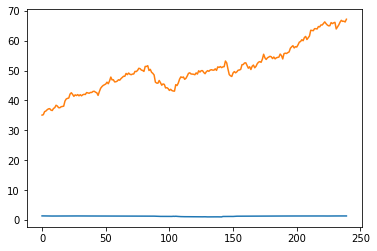





























  0%|          | 1/500 [00:13<1:49:26, 13.16s/it]



























  0%|          | 2/500 [00:24<1:44:02, 12.54s/it]



























  1%|          | 3/500 [00:35<1:40:56, 12.19s/it]



























  1%|          | 4/500 [00:47<1:40:13, 12.12s/it]



























  1%|          | 5/500 [00:59<1:39:43, 12.09s/it]



























  1%|          | 6/500 [01:11<1:38:59, 12.02s/it]



























  1%|▏         | 7/500 [01:23<1:37:38, 11.88s/it]



























  2%|▏         | 8/500 [01:34<1:36:29, 11.77s/it]



























  2%|▏         | 9/500 [01:45<1:35:19, 11.65s/it]



























  2%|▏         | 10/500 [01:57<1:34:21, 11.55s/it]



























  2%|▏         | 11/500 [02:08<1:33:39, 11.49s/it]



























  2%|▏         | 12/500 [02:19<1:32:52, 11.42s/it]



























  3%|▎         | 13/500 [02:31<1:32:24, 11.38

 10%|█         | 51/500 [09:25<1:19:26, 10.61s/it]



























 10%|█         | 52/500 [09:36<1:19:18, 10.62s/it]



























 11%|█         | 53/500 [09:47<1:19:12, 10.63s/it]



























 11%|█         | 54/500 [09:57<1:19:39, 10.72s/it]



























 11%|█         | 55/500 [10:08<1:19:31, 10.72s/it]



























 11%|█         | 56/500 [10:19<1:18:48, 10.65s/it]



























 11%|█▏        | 57/500 [10:29<1:18:28, 10.63s/it]



























 12%|█▏        | 58/500 [10:40<1:18:09, 10.61s/it]



























 12%|█▏        | 59/500 [10:50<1:17:54, 10.60s/it]



























 12%|█▏        | 60/500 [11:01<1:17:38, 10.59s/it]



























 12%|█▏        | 61/500 [11:12<1:17:22, 10.57s/it]



























 12%|█▏        | 62/500 [11:22<1:17:42, 10.64s/it]



























 13%|█▎        | 63/500 [11:33<1:17:48, 10.68s/it]















MAE
31.302086009385153



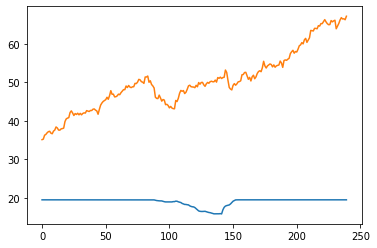





























 20%|██        | 101/500 [18:14<1:13:26, 11.04s/it]



























 20%|██        | 102/500 [18:24<1:12:22, 10.91s/it]



























 21%|██        | 103/500 [18:34<1:11:08, 10.75s/it]



























 21%|██        | 104/500 [18:45<1:10:07, 10.62s/it]



























 21%|██        | 105/500 [18:55<1:09:20, 10.53s/it]



























 21%|██        | 106/500 [19:05<1:08:46, 10.47s/it]



























 21%|██▏       | 107/500 [19:16<1:08:40, 10.49s/it]



























 22%|██▏       | 108/500 [19:27<1:08:45, 10.52s/it]



























 22%|██▏       | 109/500 [19:37<1:08:25, 10.50s/it]



























 22%|██▏       | 110/500 [19:47<1:07:54, 10.45s/it]



























 22%|██▏       | 111/500 [19:58<1:07:30, 10.41s/it]



























 22%|██▏       | 112/500 [20:08<1:07:08, 10.38s/it]



























 23%|██▎       | 113/500

 30%|███       | 151/500 [26:51<59:13, 10.18s/it]



























 30%|███       | 152/500 [27:01<58:53, 10.15s/it]



























 31%|███       | 153/500 [27:11<58:36, 10.13s/it]



























 31%|███       | 154/500 [27:21<58:24, 10.13s/it]



























 31%|███       | 155/500 [27:32<58:42, 10.21s/it]



























 31%|███       | 156/500 [27:42<58:50, 10.26s/it]



























 31%|███▏      | 157/500 [27:52<58:24, 10.22s/it]



























 32%|███▏      | 158/500 [28:02<57:58, 10.17s/it]



























 32%|███▏      | 159/500 [28:12<57:42, 10.15s/it]



























 32%|███▏      | 160/500 [28:23<57:24, 10.13s/it]



























 32%|███▏      | 161/500 [28:33<57:16, 10.14s/it]



























 32%|███▏      | 162/500 [28:43<57:29, 10.21s/it]



























 33%|███▎      | 163/500 [28:53<57:29, 10.24s/it]




























MAE
18.454721663198836



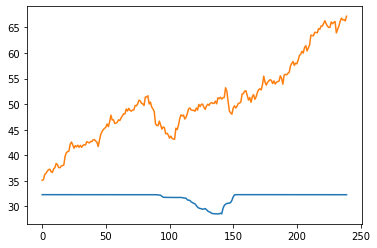





























 40%|████      | 201/500 [35:18<52:45, 10.59s/it]



























 40%|████      | 202/500 [35:28<51:40, 10.40s/it]



























 41%|████      | 203/500 [35:38<51:14, 10.35s/it]



























 41%|████      | 204/500 [35:48<50:53, 10.32s/it]



























 41%|████      | 205/500 [35:58<50:12, 10.21s/it]



























 41%|████      | 206/500 [36:08<49:36, 10.12s/it]



























 41%|████▏     | 207/500 [36:18<49:07, 10.06s/it]



























 42%|████▏     | 208/500 [36:28<48:44, 10.02s/it]



























 42%|████▏     | 209/500 [36:38<48:33, 10.01s/it]



























 42%|████▏     | 210/500 [36:48<48:41, 10.07s/it]



























 42%|████▏     | 211/500 [36:59<48:43, 10.12s/it]



























 42%|████▏     | 212/500 [37:09<48:18, 10.06s/it]



























 43%|████▎     | 213/500 [37:18<47:56, 10.02s/it

 50%|█████     | 251/500 [43:42<41:37, 10.03s/it]



























 50%|█████     | 252/500 [43:52<41:36, 10.07s/it]



























 51%|█████     | 253/500 [44:03<41:28, 10.07s/it]



























 51%|█████     | 254/500 [44:12<41:00, 10.00s/it]



























 51%|█████     | 255/500 [44:22<40:39,  9.96s/it]



























 51%|█████     | 256/500 [44:32<40:27,  9.95s/it]



























 51%|█████▏    | 257/500 [44:42<40:30, 10.00s/it]



























 52%|█████▏    | 258/500 [44:52<40:31, 10.05s/it]



























 52%|█████▏    | 259/500 [45:02<40:18, 10.04s/it]



























 52%|█████▏    | 260/500 [45:12<39:54,  9.98s/it]



























 52%|█████▏    | 261/500 [45:22<39:32,  9.93s/it]



























 52%|█████▏    | 262/500 [45:32<39:19,  9.91s/it]



























 53%|█████▎    | 263/500 [45:42<39:22,  9.97s/it]




























MAE
8.048481925341358



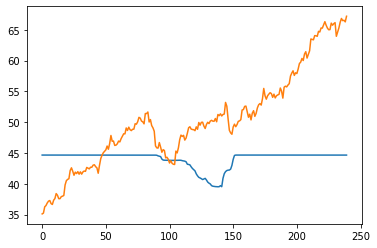





























 60%|██████    | 301/500 [52:03<35:11, 10.61s/it]



























 60%|██████    | 302/500 [52:13<34:18, 10.39s/it]



























 61%|██████    | 303/500 [52:23<33:38, 10.24s/it]



























 61%|██████    | 304/500 [52:33<33:04, 10.12s/it]



























 61%|██████    | 305/500 [52:43<32:39, 10.05s/it]



























 61%|██████    | 306/500 [52:52<32:24, 10.02s/it]



























 61%|██████▏   | 307/500 [53:02<32:12, 10.01s/it]



























 62%|██████▏   | 308/500 [53:12<31:48,  9.94s/it]



























 62%|██████▏   | 309/500 [53:22<31:39,  9.94s/it]



























 62%|██████▏   | 310/500 [53:32<31:41, 10.01s/it]



























 62%|██████▏   | 311/500 [53:42<31:30, 10.00s/it]



























 62%|██████▏   | 312/500 [53:52<31:12,  9.96s/it]



























 63%|██████▎   | 313/500 [54:02<30:56,  9.93s/it

 70%|███████   | 351/500 [1:00:15<23:46,  9.57s/it]



























 70%|███████   | 352/500 [1:00:24<23:37,  9.58s/it]



























 71%|███████   | 353/500 [1:00:34<23:29,  9.59s/it]



























 71%|███████   | 354/500 [1:00:43<23:20,  9.59s/it]



























 71%|███████   | 355/500 [1:00:53<23:11,  9.60s/it]



























 71%|███████   | 356/500 [1:01:03<23:02,  9.60s/it]



























 71%|███████▏  | 357/500 [1:01:12<22:53,  9.60s/it]



























 72%|███████▏  | 358/500 [1:01:22<22:43,  9.60s/it]



























 72%|███████▏  | 359/500 [1:01:31<22:34,  9.61s/it]



























 72%|███████▏  | 360/500 [1:01:41<22:24,  9.61s/it]



























 72%|███████▏  | 361/500 [1:01:51<22:14,  9.60s/it]



























 72%|███████▏  | 362/500 [1:02:00<22:04,  9.60s/it]



























 73%|███████▎  | 363/500 [1:02:10<21:55,  9.60s/it]


MAE
18.175057003698715



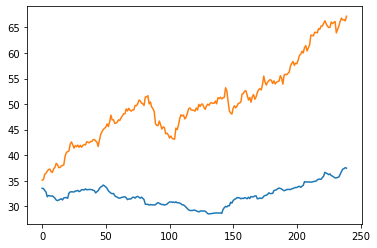





























 80%|████████  | 401/500 [1:08:16<17:05, 10.36s/it]



























 80%|████████  | 402/500 [1:08:26<16:47, 10.29s/it]



























 81%|████████  | 403/500 [1:08:36<16:36, 10.28s/it]



























 81%|████████  | 404/500 [1:08:47<16:30, 10.32s/it]



























 81%|████████  | 405/500 [1:08:57<16:26, 10.39s/it]



























 81%|████████  | 406/500 [1:09:08<16:22, 10.45s/it]



























 81%|████████▏ | 407/500 [1:09:19<16:18, 10.53s/it]



























 82%|████████▏ | 408/500 [1:09:29<16:14, 10.59s/it]



























 82%|████████▏ | 409/500 [1:09:40<16:09, 10.66s/it]



























 82%|████████▏ | 410/500 [1:09:51<16:04, 10.72s/it]



























 82%|████████▏ | 411/500 [1:10:02<16:00, 10.79s/it]



























 82%|████████▏ | 412/500 [1:10:13<15:55, 10.86s/it]



























 83%|████████▎ | 413/500

 90%|█████████ | 451/500 [1:17:12<08:36, 10.55s/it]



























 90%|█████████ | 452/500 [1:17:22<08:26, 10.56s/it]



























 91%|█████████ | 453/500 [1:17:33<08:16, 10.56s/it]



























 91%|█████████ | 454/500 [1:17:44<08:05, 10.57s/it]



























 91%|█████████ | 455/500 [1:17:54<07:55, 10.57s/it]



























 91%|█████████ | 456/500 [1:18:05<07:45, 10.58s/it]



























 91%|█████████▏| 457/500 [1:18:15<07:35, 10.58s/it]



























 92%|█████████▏| 458/500 [1:18:26<07:24, 10.59s/it]



























 92%|█████████▏| 459/500 [1:18:36<07:14, 10.59s/it]



























 92%|█████████▏| 460/500 [1:18:47<07:01, 10.53s/it]



























 92%|█████████▏| 461/500 [1:18:57<06:49, 10.51s/it]



























 92%|█████████▏| 462/500 [1:19:08<06:40, 10.54s/it]



























 93%|█████████▎| 463/500 [1:19:19<06:31, 10.57s/it]


In [560]:
returns = run_GAN()

In [567]:
returns_generated = returns[0]
returns_true = returns[1]

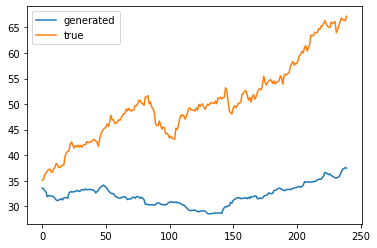

In [569]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [605]:
#MAE
mean_absolute_error(returns_generated, returns_true)

18.175057003698715

In [606]:
#calcualte generated and real returns
returns_percent_generated = []
for i in range (1, len(returns_generated)):
    returns_percent_generated.append( (returns_generated[i] - returns_generated[i-1])/returns_generated[i-1])
returns_percent_true= []
for i in range (1, len(returns_true)):
    returns_percent_true.append( (returns_true[i] - returns_true[i-1])/returns_true[i-1])

In [607]:
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)):
    if (returns_percent_generated[i] > 0):
        strategy_returns.append(returns_percent_true[i])
    else:
        strategy_returns.append(0)

1.9137289319462578
1.4325411274753184
0.00010692395144771673
0.20345949183619325
0.15071056330039215
-0.09023120905347894
0.30962343096234307


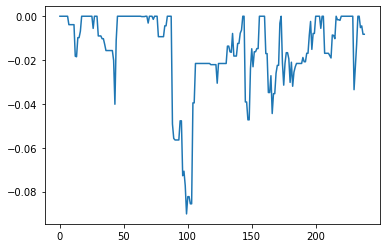

In [615]:
#eval strategy returns

#cumualtive reeturns real
cum_returns_real = 1
cum_ret_real = []
for i in range (len(returns_percent_true)):
    cum_returns_real  = cum_returns_real * (1 + returns_percent_true[i])
    cum_ret_real.append(cum_returns_real)
print (cum_returns_real)

#cumulative returns
cum_returns = 1
cum_ret = []
for i in range (len(strategy_returns)):
    cum_returns  = cum_returns * (1 + strategy_returns[i])
    cum_ret.append(cum_returns)
print (cum_returns)

#variance
variance = np.var(strategy_returns)
print (variance)

#sharpe real
std = np.std(returns_percent_true)
rfr = 0
sharpe = (np.average(returns_percent_true)- rfr)/std
print (sharpe)

#sharpe
std = np.std(strategy_returns)
rfr = 0
sharpe = (np.average(strategy_returns) - rfr)/std
print (sharpe)

#drawdown
previous_peaks = np.maximum.accumulate(cum_ret)
drawdown = (cum_ret-previous_peaks)/previous_peaks
max_drawdown = np.ndarray.min(drawdown)
print (max_drawdown)
plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

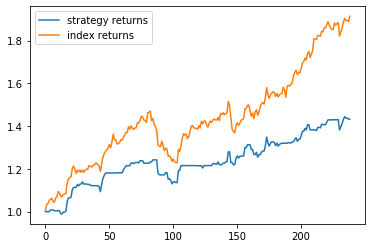

In [616]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [612]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



-96.55731129591832


In [618]:
np.var(strategy_returns)*100

0.010692395144771674

In [614]:
std

0.010340403833879833